In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from functions import sugar_classifier
from preprocessor_class import Preprocessor

####  Project Outline and Goal

![model_example](Images/model_example.png)

The goal of this project is to build a supervised machine learning model that can predict the sugar content of a menu item.  This model will be able to read the text-based information printed on a menu and make a prediction that can allow you to make an informed decision.

### **Business Problem**

Have you ever been on a diet and been invited out to dinner or wanted take-out?  It can be frustrating to lose track of nutritional intake when eating at a restaurant and you stand the risk of unwittingly ordering something that is unhealthy or outside of your diet's restrictions.

Some menus will provide calorie counts, but that is only helpful for weight gain/loss and does not take into account other health concerns such as diabetes and some forms of heart disease.  What can you do when the only information you have is the title of a dish, short description, and a price?

### The Data

The data for this project was collected by the Department of Health and Mental Hygiene (DOHMH) and is available to the public from the NYC OpenData website.  The .csv contains over 60,000 menu items available at chain restaurants throughout New York City.  All data was collected between 2017-2018 and was made public on 5/10/2018.  For more information or to download, visit [NYC OpenData's webpage for this dataset](https://data.cityofnewyork.us/Health/DOHMH-MenuStat-Historical-/qgc5-ecnb/about_data)

The menus contained within my data are large chains with one or more franchises within New York City borders.  Overall, there were 86 restaurants represented with a combined total of 65,219 menu items.  Each menu item had information on the restaurant, menu text, food category, serving size, and nutrition facts such as calories, sugar, fats, sodium, and more.

In [3]:
df_raw = pd.read_csv('Data/menu_items.csv', low_memory = False)
df_raw.head()

,Menu_Item_ID,Year,Restaurant_Item_Name,restaurant,Restaurant_ID,Item_Name,Item_Description,Food_Category,Serving_Size,Serving_Size_text,...,Sodium_text,Potassium_text,Carbohydrates_text,Protein_text,Sugar_text,Dietary_Fiber_text,Kids_Meal,Limited_Time_Offer,Regional,Shareable
0,35005,2017,7 Eleven Mocha Iced Coffee,7 Eleven,1,Mocha Iced Coffee,"Mocha Iced Coffee, Chillers Iced Coffee, Drinks",Beverages,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,0
1,35008,2017,7 Eleven French Vanilla Iced Coffee,7 Eleven,1,French Vanilla Iced Coffee,"French Vanilla Iced Coffee, Chillers Iced Coff...",Beverages,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,0
2,35027,2017,7 Eleven French Vanilla Cappuccino,7 Eleven,1,French Vanilla Cappuccino,"French Vanilla Cappuccino, Coffee, Drinks, Fla...",Beverages,8.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,0,0,1,0
3,35028,2017,7 Eleven Peppermint Mocha,7 Eleven,1,Peppermint Mocha,"Peppermint Mocha, Coffee, 8 fl oz",Beverages,8.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,0
4,35029,2017,7 Eleven Pumpkin Spice Latte,7 Eleven,1,Pumpkin Spice Latte,"Pumpkin Spice Latte, Coffee, 8 fl oz",Beverages,8.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,0,0,1,0


In [3]:
df_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 65219 entries, 0 to 65218
Data columns (total 49 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Menu_Item_ID            65219 non-null  int64  
 1   Year                    65219 non-null  int64  
 2   Restaurant_Item_Name    65219 non-null  object 
 3   restaurant              65219 non-null  object 
 4   Restaurant_ID           65219 non-null  int64  
 5   Item_Name               65219 non-null  object 
 6   Item_Description        65219 non-null  object 
 7   Food_Category           65219 non-null  object 
 8   Serving_Size            26899 non-null  float64
 9   Serving_Size_text       39 non-null     object 
 10  Serving_Size_Unit       26927 non-null  object 
 11  Serving_Size_household  15238 non-null  object 
 12  Calories                55315 non-null  float64
 13  Total_Fat               54846 non-null  float64
 14  Saturated_Fat           54143 non-null

####  Data Cleaning

The first step was to clean the data and set it up in a way that it can be used to train the model.  The steps I took were:

1.  Feature Selection
2.  Deal with Missing Data
3.  Bin Sugar Contents
4.  Explore/Understand Data
5.  Prepare Text
6.  Save to .csv

#### Step 1:  Feature Selection

First, I isolated the data to all of the text information and the target variable, 'Sugar'.  Most of the text was used for NLP, but I specifically kept the 'restaurant' column, or restaurant name, so that I could later remove that specific string from the item descriptions.

In [4]:
relevant_columns = ['Restaurant_Item_Name', 'restaurant', 'Item_Name', 'Item_Description', 'Food_Category', 'Sugar']
df_relevant = df_raw.loc[:, relevant_columns]
df = df_relevant.sort_values(by = 'Sugar', ascending = False)
df = df.reset_index(drop = True)

#### Step 2:  Missing Data

There were several rows throughout the dataset with various parts of nutrition facts omitted.  In this case, there were 12,288 items with missing sugar values.

I decided it was best to remove these rows.  Although more data will always be helpful, especially for supervised learning models, I didn't want to impute the data and have various word tokens lose or gain inappropriate levels of significance.  Ultimately, this left me with 52,931 rows with the data I needed.

In [5]:
df.isna().sum()

Restaurant_Item_Name        0
restaurant                  0
Item_Name                   0
Item_Description            0
Food_Category               0
Sugar                   12288
dtype: int64

In [6]:
df.dropna(inplace = True)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 52931 entries, 0 to 52930
Data columns (total 6 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Restaurant_Item_Name  52931 non-null  object 
 1   restaurant            52931 non-null  object 
 2   Item_Name             52931 non-null  object 
 3   Item_Description      52931 non-null  object 
 4   Food_Category         52931 non-null  object 
 5   Sugar                 52931 non-null  float64
dtypes: float64(1), object(5)
memory usage: 2.8+ MB


#### Step 3:  Binned Sugar Values

Initially, I considered a regression model to make predictions on specific sugar values given input text.  However, I felt that the amount of data I had was insufficient to make accurate predictions on that level.  In addition, I wanted my results to be interpretable for an end user who just wants to know at a glance which menu items would be appropriate to order.  Practically speaking, the target user doesn't need to know whether the menu item has 75 or 80g of sugar.  They just need to know that it's too much sugar!

I binned the sugar values into 5 categories according to the quartiles represented in the data with a 5th added category for menu items with 0g sugar.  These quartiles were conveniently in accordance with recommended sugar intake.

The [USDA 2020-2025 Dietary Guidelines fo Americans](https://www.dietaryguidelines.gov/sites/default/files/2020-12/Dietary_Guidelines_for_Americans_2020-2025.pdf), defines a healthy diet as having no more than 10% of daily calorie intake coming from sugar.  Most people's daily recommended calorie intake is between 2,000 and 2,500, limiting diets to no more than 200-250 calories in sugar.  This equates to about 50-60g, so this class of menu item would be half or more of a day's healthy sugar intake.  Further, the American Heart Association (AHA) [recommends no higher than 6% of daily calorie intake coming from sugar](https://www.heart.org/en/healthy-living/healthy-eating/eat-smart/sugar/added-sugars).

This left me with the following categories:

1.  Very High Sugar (5) - Menu items with greater than 30g sugar.  These items would either make up 50+% of your daily sugar intake according to the USDA.  If you were to follow the AHA's recommendations, an item in this category would exceed your entire day's sugar intake!
2.  High Sugar (4) - Menu items with between 7 and 30 grams of sugar.  Choosing an item in this category would mean consuming a substantial portion of your daily sugar, but not all.
3.  Medium Sugar (3) - Menu items with between 2 and 7 grams of sugar.  These items definitely contain some sugar and may be important for diabetics or those with medical concerns to be aware of.
4.  Low Sugar (2) - Menu items with between 0 and 2 grams of sugar.  These items are pretty safe!  However, if you are looking for choices that are completely sugar free, it would be important to know that these items are not 100% sugar-free.
5.  Zero Sugar (1) - Menu items with exactly 0g sugar.

In [7]:
df.describe()

,Sugar
count,52931.000000
mean,21.902446
std,34.088833
min,0.000000
25%,2.000000
50%,7.000000
75%,30.000000
max,783.000000


In [8]:
df['sugar_class'] = df['Sugar'].apply(sugar_classifier)
df.sample(n = 5, random_state = 300)

,Restaurant_Item_Name,restaurant,Item_Name,Item_Description,Food_Category,Sugar,sugar_class
49053,Zaxby's Unsweet Tea,Zaxby's,Unsweet Tea,"Unsweet Tea, Beverages, 42 oz",Beverages,0.0,1
39101,Yard House Guacamole & Chips,Yard House,Guacamole & Chips,"Guacamole & Chips w/ Pico de Gallo & Feta, Snacks",Appetizers & Sides,2.0,2
5673,"Culver's Vanilla Cake Cone, 3 Scoops",Culver's,"Vanilla Cake Cone, 3 Scoops",Vanilla Cake Cone w/ Vanilla Fresh Frozen Cust...,Desserts,63.0,5
7410,Panera Bread Pumpkin Muffin,Panera Bread,Pumpkin Muffin,"Pumpkin Muffin, Muffins & Muffies, Pastries & ...",Baked Goods,52.0,5
20417,California Pizza Kitchen Quinoa & Arugula Sala...,California Pizza Kitchen,Quinoa & Arugula Salad w/ Grilled Chicken Brea...,Quinoa & Arugula Salad w/ Grilled Chicken Brea...,Salads,13.0,4


#### Step 4:  Explore/Understand Data

At this point, I wanted to take a minute to look at the data with a wider perspective.  Although the text will processed in a way that will be universal, I thought it was important for intepreting results to look at some statistics.  For instance, we see that Starbucks and Dunkin' Donuts provide the most information out of all the represented restaurants.  This means that we are going to have lots of data on words like "whipped", "caramel", "mocha", and "chocolate".  Although this is not necessarily problematic, it is worth noting and something I will address in my conclusion's "Next Steps" findings.

In [9]:
df

,Restaurant_Item_Name,restaurant,Item_Name,Item_Description,Food_Category,Sugar,sugar_class
0,"Dairy Queen Cookie Dough Blizzard Cake, 10 in",Dairy Queen,"Cookie Dough Blizzard Cake, 10 in","Cookie Dough Blizzard Cake, 10 in w/ Vanilla S...",Desserts,783.0,5
1,Dairy Queen Reeses Peanut Butter Cups Blizzard...,Dairy Queen,"Reeses Peanut Butter Cups Blizzard Cake, 10 in","Reeses Peanut Butter Cups Blizzard Cake, 10 in...",Desserts,737.0,5
2,"Dairy Queen Chocolate Xtreme Blizzard Cake, 10 in",Dairy Queen,"Chocolate Xtreme Blizzard Cake, 10 in","Chocolate Xtreme Blizzard Cake, 10 in w/ Brown...",Desserts,735.0,5
3,"Dairy Queen Oreo Blizzard Cake, 10 in",Dairy Queen,"Oreo Blizzard Cake, 10 in","Oreo Blizzard Cake, 10 in w/ Oreo Cookie Piece...",Desserts,720.0,5
4,"Dairy Queen DQ Round Cake, 10 in",Dairy Queen,"DQ Round Cake, 10 in","DQ Round Cake w/ Cake Crunch Filling, Chocolat...",Desserts,569.0,5
...,...,...,...,...,...,...,...
52926,Popeyes 6 Nuggets,Popeyes,6 Nuggets,"6 Nuggets, Tenders",Entrees,0.0,1
52927,"Popeyes Breast, Bonafide Spicy Chicken",Popeyes,"Breast, Bonafide Spicy Chicken","Breast, Bonafide Spicy Chicken",Entrees,0.0,1
52928,"Popeyes Thigh, Bonafide Spicy Chicken",Popeyes,"Thigh, Bonafide Spicy Chicken","Thigh, Bonafide Spicy Chicken, 300 Calories or...",Entrees,0.0,1
52929,"Popeyes Leg, Bonafide Spicy Chicken",Popeyes,"Leg, Bonafide Spicy Chicken","Leg, Bonafide Spicy Chicken, 200 Calories or U...",Entrees,0.0,1


In [92]:
value_counts = df['restaurant'].value_counts()
for value, count in value_counts.items():
    print(f'{value}: {count}')
top_15_restaurants = dict(value_counts.iloc[:15])
print("")
print("================================")
print("")

average_no_menu_items = value_counts.mean()

print("Average number of menu items per restaurant:")
print(average_no_menu_items)

Starbucks: 3565
Wawa: 2410
Dunkin' Donuts: 1785
Jersey Mike's Subs: 1585
Sheetz: 1584
Sonic: 1553
Golden Corral: 1351
Papa John's: 1165
Firehouse Subs: 1134
Pizza Hut: 1017
Perkins: 991
Dominos: 927
Dairy Queen: 847
Quiznos: 816
Round Table Pizza: 814
Jason's Deli: 813
BJ's Restaurant & Brewhouse: 813
IHOP: 774
Chili's: 725
Red Robin: 719
White Castle: 715
Frisch's Big Boy: 707
Steak 'N Shake: 685
Bob Evans: 667
Culver's: 654
Baskin Robbins: 650
Taco Bell: 638
Whataburger: 632
California Pizza Kitchen: 622
Tim Hortons: 600
Red Lobster: 594
Papa Murphy's: 591
Yard House: 590
Denny's: 582
Panera Bread: 578
Marco's Pizza: 577
Famous Dave's: 575
Friendly's: 574
Jack in the Box: 552
Applebee's: 536
Einstein Bros: 517
McDonald's: 515
McAlister's Deli: 510
Zaxby's: 504
TGI Friday's: 457
Subway: 443
LongHorn Steakhouse: 432
Ruby Tuesday: 429
Olive Garden: 419
Krispy Kreme: 417
Wendy's: 412
KFC: 393
O'Charley's: 390
Carrabba's Italian Grill: 389
Burger King: 388
Jamba Juice: 387
PF Chang's: 376

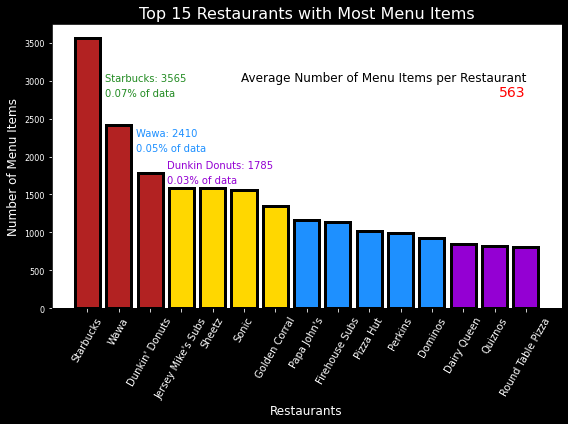

In [115]:
fig, ax = plt.subplots(figsize = (8, 6), facecolor = 'black')
x = list(top_15_restaurants.keys())
y = list(top_15_restaurants.values())
colors = ['firebrick', 'firebrick', 'firebrick',
          'gold', 'gold', 'gold', 'gold',
          'dodgerblue', 'dodgerblue', 'dodgerblue', 'dodgerblue', 'dodgerblue',
          'darkviolet', 'darkviolet', 'darkviolet']
border_thickness = 3
ax.bar(x, y, color = colors, edgecolor = 'black', linewidth = border_thickness)
ax.set_title('Top 15 Restaurants with Most Menu Items', fontsize = 16, color = 'white')
ax.set_ylabel('Number of Menu Items', color = 'white', fontsize = 12)
ax.set_xlabel('Restaurants', color = 'white', fontsize = 12)
ax.tick_params(axis = 'x', rotation = 60, colors = 'white', labelsize = 10)
ax.tick_params(axis = 'y', colors = 'white', labelsize = 8)
plt.text(0.55, 3000, 'Starbucks: 3565', ha = 'left', color = 'forestgreen')
plt.text(0.55, 2800, f"{(3565 / 52931):.2f}% of data", ha = 'left', color = 'forestgreen')
plt.text(1.55, 2275, 'Wawa: 2410', ha = 'left', color = 'dodgerblue')
plt.text(1.55, 2075, f"{(2410 / 52931):.2f}% of data", ha = 'left', color = 'dodgerblue')
plt.text(2.55, 1850, 'Dunkin Donuts: 1785', ha = 'left', color = 'darkviolet')
plt.text(2.55, 1650, f"{(1785 / 52931):.2f}% of data", ha = 'left', color = 'darkviolet')
plt.text(14, 3000, 'Average Number of Menu Items per Restaurant', ha = 'right', fontsize = 12)
plt.text(14, 2800, f"{round(average_no_menu_items)}", ha = 'right', color = 'red', fontsize = 14)
plt.tight_layout()
plt.savefig('Images/top_15_restaurants_graph.png')
plt.show()

#### Step 5:  Prepare Text

To prepare the text, I combined the strings together and removed the restaurant names from the text.  It is important to note that some words will appear multiple times in each text block.  This will be addressed in my imported Preprocessor class that can be found in the preprocessor_class.py file in the repo.  However, it does help form the raw text block that makes up the independent variable.

In [9]:
df['text'] = df['Restaurant_Item_Name'] + " " + df['Item_Name'] + " " + df['Item_Description'] + " " + df['Food_Category']
df.drop(columns = ['Restaurant_Item_Name', 'Item_Name', 'Item_Description', 'Food_Category', 'Sugar'], inplace = True)

In [10]:
df['restaurant'] = df['restaurant'].str.split()
for index, row in df.iterrows():
    for string in row['restaurant']:
        df.at[index, 'text'] = df.at[index, 'text'].replace(string, '')
df.drop(columns = 'restaurant', inplace = True)

In [11]:
df.sample(n = 5, random_state = 200)

,sugar_class,text
21688,4,Deconstructed Breakfast Taco Deconstructed Br...
42983,2,Lay's Kettle Cooked 40% Less Fat Original La...
26327,4,"Chicken Maui Zaui w/ Polynesian Sauce, Pan,..."
31076,3,"All Meat Pizza on Gluten Free Crust, Medium,..."
13655,4,El Nino Margarita El Nino Margarita El Nino M...


#### Step 6:  Save to .csv

At this point, I saved the data to a new .csv file that can be referenced later so the above code does not need to be re-ran in each notebook.

In [169]:
df.to_csv('Data/prepared_text_data_sugar.csv', index = False)